# Abalone Dataset Regression

Author: **Marcin Sikorski**<br>
Date: February, 2025

Update on predicting abalone rings (continuous data) as a regression task. This notebook includes basic exploratory data analysis (EDA) and various approaches for estimating the target values.

**Notebook Content:**
1. Loading Data and EDA
2. Normalizing and Splitting Data
3. Multilayer Perceptron
4. CatBoost Regressor
5. TensorFlow Neural Network
6. Gaussian Process Regressor
7. Conclusions

### 1. Loading Data and EDA

The dataset will be loaded and investigated to summarize its main characteristics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

seed_value = 42
np.random.seed(seed_value)

# import data and create dataframe
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
df = pd.read_csv(url, header=None)
    
# header
df.columns = [
    'sex', 'length', 'diameter', 'height', 'whole_weight',
    'shucked_weight', 'viscera_weight', 'shell_weight', 'rings',
]

print('Number of samples: %d' % len(df))
df.head()

Number of samples: 4177


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [2]:
# get column names, null value counts, and data types
col_list = df.columns.to_list()
null_list = df.isna().sum().to_list()
dtype_list = df.dtypes.to_list()

# summary dataframe
df_sum = pd.DataFrame({
    'Feature': col_list,
    'Null Values': null_list,
    'Data Type': dtype_list
})

df_sum.style.hide(axis='index')

Feature,Null Values,Data Type
sex,0,object
length,0,float64
diameter,0,float64
height,0,float64
whole_weight,0,float64
shucked_weight,0,float64
viscera_weight,0,float64
shell_weight,0,float64
rings,0,int64


In [3]:
# unique values in 'sex' column
df['sex'].unique().tolist()

['M', 'F', 'I']

>'M' sex stands for male, 'F' for female, and 'I' for infant. This is not suitable for machine learning algorithms, so we will create a binary feature for each of the three options.

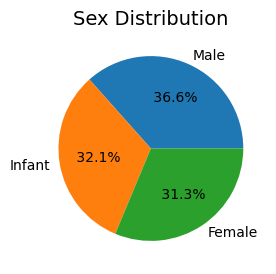

In [4]:
# plot gender distribution
label_mapping = {'M': 'Male', 'I': 'Infant', 'F': 'Female'}

sex_values = df['sex'].map(label_mapping).value_counts()
sex_labels = ['Male', 'Infant', 'Female']

plt.figure(figsize=(3, 3))
plt.pie(sex_values, labels=sex_labels, autopct=lambda p: f'{p: .1f}%')
plt.title('Sex Distribution', size=14)
plt.show()

> The gender distribution is fairly balanced.

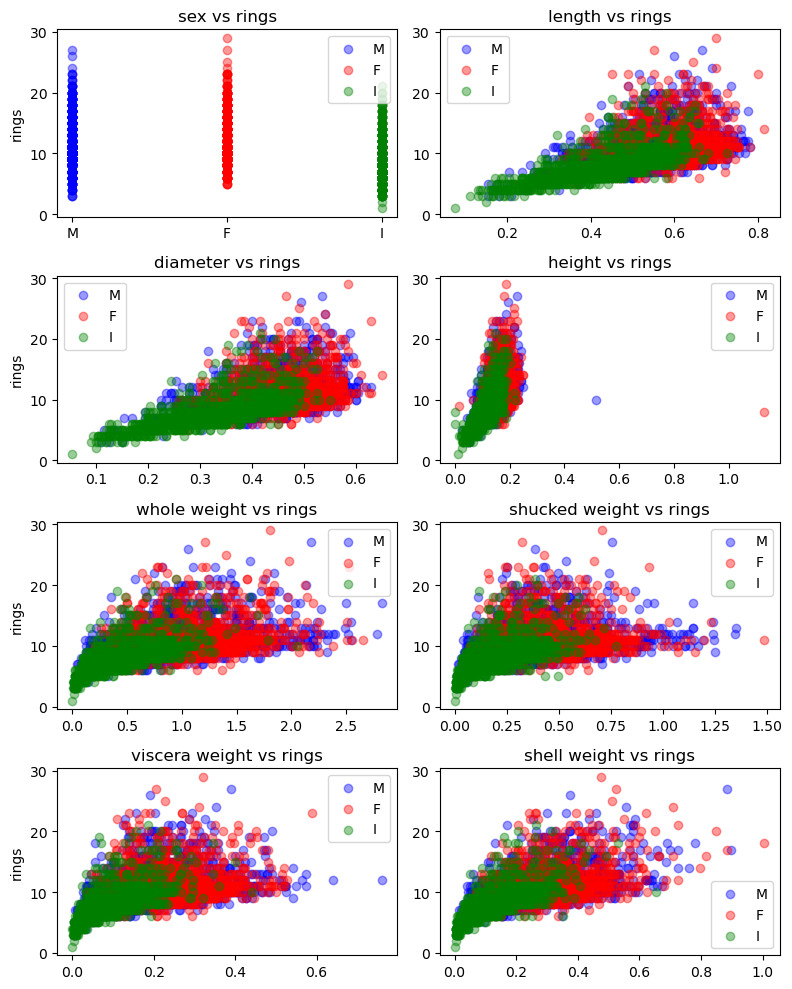

In [5]:
# plot feature correlations categorized by sex
# list of features and drop 'rings' value
feature_list = df.columns.tolist()
#feature_list = [x for x in val if x != 'rings']
del feature_list[-1]

# map colors based on sex
color_map = {'M': 'blue', 'F': 'red', 'I': 'green'}

fig, axes = plt.subplots(4, 2, figsize=(8, 10))
axes = axes.flatten()

for i, feature in enumerate(feature_list):
    ax = axes[i]
    for sex in df['sex'].unique():
        sex_data = df[df['sex'] == sex]
        ax.scatter(sex_data[feature], sex_data['rings'], label=sex, color=color_map[sex], alpha=0.4)
    
    ax.set_title(f'{feature.replace('_', ' ')} vs rings')
    # set ylabel only for the leftmost subplots
    if i % 2 == 0:
        ax.set_ylabel('rings')
    ax.legend()

plt.tight_layout()
plt.show()

> While there are overall correlations between variables and the target, the sex category does not describe much. No specific patterns are visible. Both males and females seem to have the same dimensions. Infant abalones tend to be visually smaller.

This dataset contains possible outliers. However, we will leave them untouched.

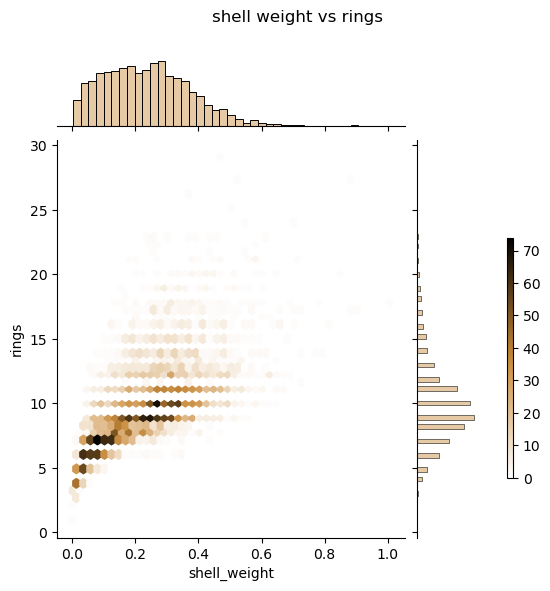

In [6]:
# plot density plot
# outliers stretch frame limits, plot highlights how concentrated the features are
hexplot = sns.jointplot(data=df, x='shell_weight', y='rings', kind='hex', color='burlywood', height=6)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1) # make space for cbar
hexplot.fig.suptitle('shell weight vs rings')

# colorbar settings
cbar_ax = hexplot.fig.add_axes(rect=[0.85, 0.2, 0.01, 0.4])
plt.colorbar(cax=cbar_ax)

plt.show()

> Abalones with rings in range from 5 to 10 are the most numerous. Ring values upon 20 are infrequent.

In [7]:
# perform one-hot encoding
df = pd.get_dummies(df, dtype=int)
df.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [8]:
# descriptive statistics
round(df.describe(), 4)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
count,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000,4177.0000
mean,0.5240,0.4079,0.1395,0.8287,0.3594,0.1806,0.2388,9.9337,0.3129,0.3213,0.3658
std,0.1201,0.0992,0.0418,0.4904,0.2220,0.1096,0.1392,3.2242,0.4637,0.4670,0.4817
min,0.0750,0.0550,0.0000,0.0020,0.0010,0.0005,0.0015,1.0000,0.0000,0.0000,0.0000
25%,0.4500,0.3500,0.1150,0.4415,0.1860,0.0935,0.1300,8.0000,0.0000,0.0000,0.0000
50%,0.5450,0.4250,0.1400,0.7995,0.3360,0.1710,0.2340,9.0000,0.0000,0.0000,0.0000
75%,0.6150,0.4800,0.1650,1.1530,0.5020,0.2530,0.3290,11.0000,1.0000,1.0000,1.0000
max,0.8150,0.6500,1.1300,2.8255,1.4880,0.7600,1.0050,29.0000,1.0000,1.0000,1.0000


> We can spot 0 valued heights which does not make any sense. These are probably errors provided during data collecting.

In [9]:
# instances with 0 value
df.loc[df['height'] == 0.0]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
1257,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8,0,1,0
3996,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6,0,1,0


In [10]:
# drop instances with 0 value
df = df[df['height'] != 0.0]

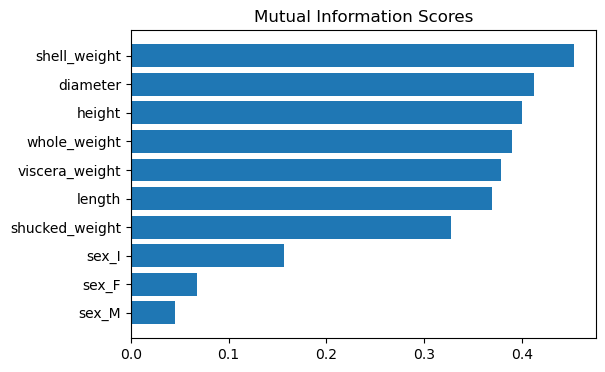

In [11]:
from sklearn.feature_selection import mutual_info_regression

y = df['rings']
X = df.drop('rings', axis=1)

discrete_features = X.dtypes.apply(lambda dtype: np.issubdtype(dtype, np.integer))
scores = mutual_info_regression(X=X, y=y, discrete_features=discrete_features)

# list scores and features
features = list(X.columns)
scores = list(scores)

# sort in descending order of score
sorted_indices = np.argsort(scores)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

plt.figure(figsize=(6, 4))
plt.barh(y=sorted_features[::-1], width=sorted_scores[::-1], align='center')
plt.title('Mutual Information Scores')
plt.show()

> The sex features have weak dependencies with the target feature and might cause noise. We will ensure the top three features are not highly correlated with one another, as this might cause redundancy. They look like they can capture overlapping aspects of the data. We can combine them into a single feature, for example:
> $$(\text{shell weight} + \text{diameter} + \text{whole weight}) / 3.$$

In [12]:
# examine correlations
df[['shell_weight', 'diameter', 'whole_weight']].corr()

,shell_weight,diameter,whole_weight
shell_weight,1.000000,0.906084,0.955924
diameter,0.906084,1.000000,0.925414
whole_weight,0.955924,0.925414,1.000000


In [13]:
# add new feature
df['shell_metric'] = df.apply(lambda row: (row['shell_weight'] + row['diameter'] + row['whole_weight']) / 3, axis=1)

### 2. Normalizing and Splitting Data

We will split our data into target vector $y$ and feature matrix $X$. The characteristics will be then transformed and scaled for further machine learning. Finally, the dataset will be splitted into training and testing sets with 75:25 ratio.

In [14]:
# features to drop (exclude)
exclude = ['rings', 'sex_F', 'sex_M', 'sex_I', 'shell_weight', 'diameter', 'whole_weight']

y = df['rings'].values
X = df.drop(exclude, axis=1).values

In [15]:
from sklearn.preprocessing import MinMaxScaler

X_scale = MinMaxScaler().fit_transform(X)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, train_size=0.75, test_size=0.25)

print('Train data: %d' % len(X_train))
print('Test data: %d' % len(X_test))

Train data: 3131
Test data: 1044


### 3. Multilayer Perceptron

The first regressor will be a simple feedforward neural network with the following characteristics:
* architecture: three hidden layers with 256, 256, and 4, respectively;
* learning rate: a constant learning rate equal 0.01 throughout the training process;
* activation function: ReLU;
* optimization algorithm: Adam optimizer will be used for weight updates;
* iterations: max 100 for training;
* convergence criterion (tolerance): the fitting process will stop if the loss does not improve by at least 0.0001.

In [17]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(256, 256, 4),
    max_iter=100,
    activation='relu',
    solver='adam',
    learning_rate='constant',
    learning_rate_init=1e-2,
    tol=1e-4,
    verbose=True,
    batch_size='auto',
    random_state=42,
).fit(X_train, y_train)

Iteration 1, loss = 16.99579902
Iteration 2, loss = 4.67967218
Iteration 3, loss = 4.02966516
Iteration 4, loss = 3.71745996
Iteration 5, loss = 3.58213768
Iteration 6, loss = 3.48172406
Iteration 7, loss = 3.35093028
Iteration 8, loss = 3.22511692
Iteration 9, loss = 3.07906561
Iteration 10, loss = 2.95919478
Iteration 11, loss = 2.87635850
Iteration 12, loss = 2.71425068
Iteration 13, loss = 2.68339533
Iteration 14, loss = 2.53705108
Iteration 15, loss = 2.46073291
Iteration 16, loss = 2.45393659
Iteration 17, loss = 2.53274435
Iteration 18, loss = 2.88609831
Iteration 19, loss = 2.42683824
Iteration 20, loss = 2.43803827
Iteration 21, loss = 2.51054580
Iteration 22, loss = 2.54644380
Iteration 23, loss = 2.32988383
Iteration 24, loss = 2.51666720
Iteration 25, loss = 2.44131375
Iteration 26, loss = 2.46810670
Iteration 27, loss = 2.53463991
Iteration 28, loss = 2.32789824
Iteration 29, loss = 2.27953445
Iteration 30, loss = 2.27776190
Iteration 31, loss = 2.43955120
Iteration 32, lo

In [18]:
exclude = ['rings', 'sex_F', 'sex_M', 'sex_I', 'shell_weight', 'diameter', 'whole_weight']

# extract dataset header
feature_list = df.columns.tolist()
feature_list = [x for x in feature_list if x not in exclude]
feature_list

['length', 'height', 'shucked_weight', 'viscera_weight', 'shell_metric']

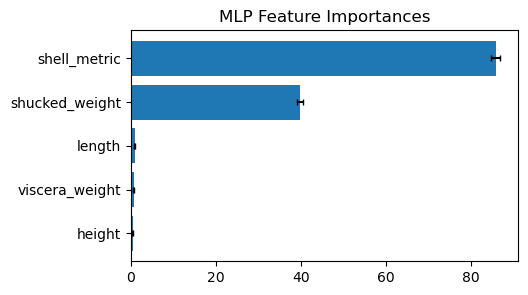

In [19]:
from sklearn.inspection import permutation_importance

# compute permutation importance
results = permutation_importance(mlp, X_train, y_train, scoring='neg_mean_squared_error')

# get importance values: mean, std
importances = results.importances_mean
importances_std = results.importances_std

# sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = np.array(feature_list)[sorted_idx]
sorted_importances = importances[sorted_idx]
sorted_std = importances_std[sorted_idx]

plt.figure(figsize=(5, 3))
plt.barh(y=sorted_features[::-1], width=sorted_importances[::-1], xerr=sorted_std[::-1], align='center', capsize=2)
plt.title('MLP Feature Importances')
plt.show()

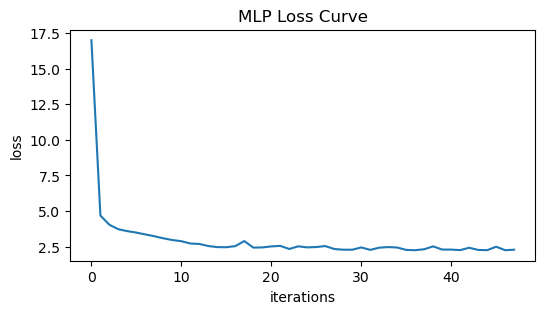

In [20]:
losses = mlp.loss_curve_

# visualize the loss curve
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.title('MLP Loss Curve')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [21]:
import sklearn.metrics as metrics

# float estimates
mlp_pred_train = mlp.predict(X_train)
mlp_pred_test = mlp.predict(X_test)

# print evaluation metrics for both the test dataset and train dataset
def eval_metrics(train_pred, test_pred):
    test_metrics = []
    
    test_metrics.append(metrics.mean_squared_error(y_test, test_pred))
    test_metrics.append((y_test - test_pred).std())
    test_metrics.append(metrics.r2_score(y_test, test_pred))
    test_metrics.append(metrics.mean_absolute_error(y_test, test_pred))

    train_metrics = []
    
    train_metrics.append(metrics.mean_squared_error(y_train, train_pred))
    train_metrics.append((y_train - train_pred).std())
    train_metrics.append(metrics.r2_score(y_train, train_pred))
    train_metrics.append(metrics.mean_absolute_error(y_train, train_pred))

    df_eval = pd.DataFrame({
        'Test': test_metrics,
        'Train': train_metrics,
    }, index=['MSE', 'RMSE', 'R²', 'MAE'])

    return df_eval.T

eval_metrics(mlp_pred_train, mlp_pred_test)

,MSE,RMSE,R²,MAE
Test,4.307223,2.071724,0.561825,1.463248
Train,4.426495,2.091272,0.581638,1.475529


> The train and test scores are close, suggesting the model generalizes very well and does not overfit or underfit the data. The R² suggests that the model captures more than half of the variability in the target variable. The MAE being slightly smaller than the RMSE indicates that the error distribution is relatively even, with no extremely large outliers significantly inflating the RMSE. The model is well-balanced between bias and variance.

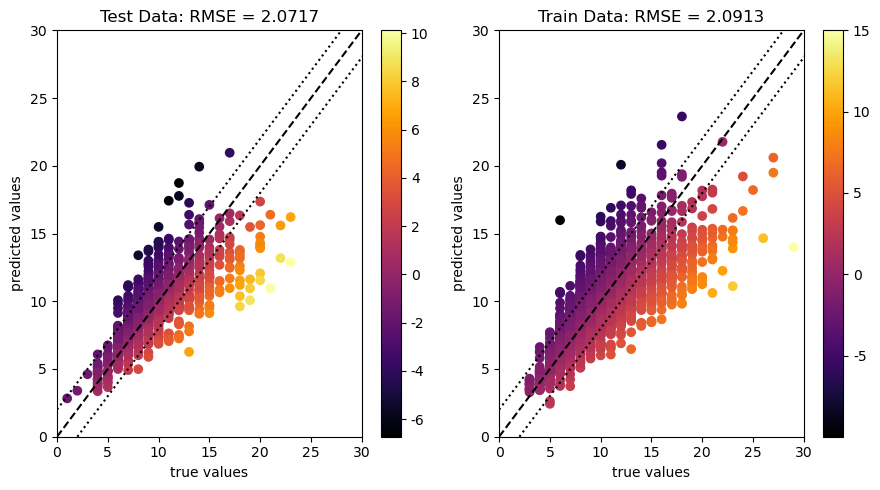

In [22]:
from matplotlib.ticker import FormatStrFormatter

# scatter plot the predicted vs true number of rings and their residuals
def scatter_res(ax, true_val, pred_val, title):
    residuals = true_val - pred_val
    scatter = ax.scatter(true_val, pred_val, c=residuals, cmap='inferno')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.formatter = FormatStrFormatter('%.0f')
    cbar.update_ticks()
    
    # plot:
    # perfect agreement line
    # +2/-2 number dotted lines
    ax.plot([0, 30], [0, 30], '--k')
    ax.plot([0, 30], [2, 32], ':k')
    ax.plot([2, 32], [0, 30], ':k')

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    ax.set_xlabel('true values')
    ax.set_ylabel('predicted values')
    ax.set_title(title)

# plot residuals
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

title1 = f'Test Data: RMSE = %.5g' % (y_test - mlp_pred_test).std()
title2 = f'Train Data: RMSE = %.5g' % (y_train - mlp_pred_train).std()

scatter_res(axes[0], y_test, mlp_pred_test, title1)
scatter_res(axes[1], y_train, mlp_pred_train, title2)

plt.tight_layout()
plt.show()

> Again, the model generalizes very well and the differences are likely due to regularization or statistical fluctuations. There are no obvious patterns in both sets. The spread range of residuals in both subsets are similar.

### 4. CatBoost Regressor

The next algorithm will be CatBoost (Categorical Boosting), which is a high-performance gradient-boosting technique.

In [23]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor(
    loss_function='RMSE',
    random_state=42,
).fit(X_train, y_train, verbose=False, cat_features=None)

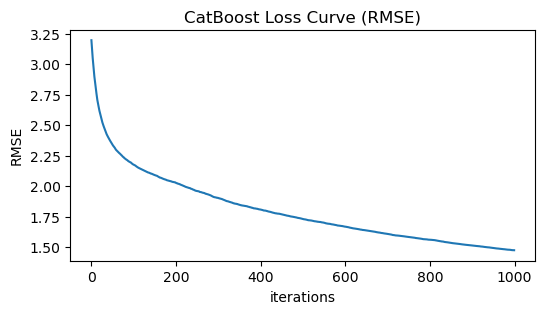

In [24]:
# get the evaluation results (RMSE)
errors = cbr.get_evals_result()['learn']['RMSE']

# visualize the loss curve
plt.figure(figsize=(6, 3))
plt.plot(errors)
plt.title('CatBoost Loss Curve (RMSE)')
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.show()

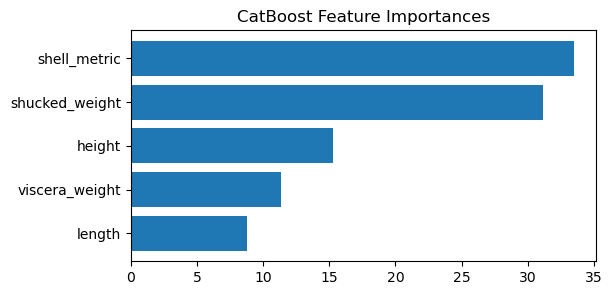

In [25]:
# plot CatBoost's feature importances
# this method does not provide std values
importances = cbr.feature_importances_

dictionary = dict(zip(feature_list, importances))
scores = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}

plt.figure(figsize=(6, 3))
plt.barh(y=list(scores.keys()), width=list(scores.values()), align='center')
plt.title('CatBoost Feature Importances')
plt.show()

In [26]:
cbr_pred_train = cbr.predict(X_train)
cbr_pred_test = cbr.predict(X_test)

# display evaluation scores
eval_metrics(cbr_pred_train, cbr_pred_test)

,MSE,RMSE,R²,MAE
Test,4.645874,2.153537,0.527374,1.539064
Train,2.174585,1.474647,0.794473,1.093559


> The model displays signs of overfitting. The training scores are substantially better than the test scores, indicating that the model captures the patterns in the training data well but struggles to generalize to unseen data.

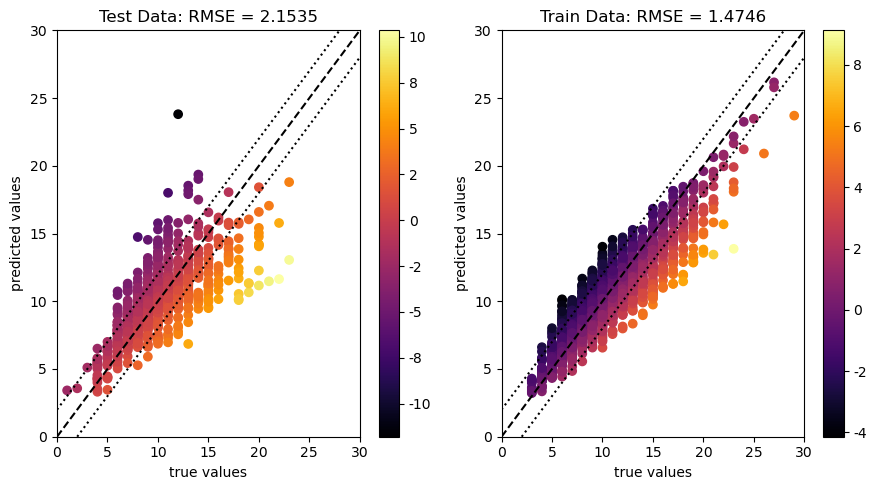

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

title1 = f'Test Data: RMSE = %.5g' % (y_test - cbr_pred_test).std()
title2 = f'Train Data: RMSE = %.5g' % (y_train - cbr_pred_train).std()

scatter_res(axes[0], y_test, cbr_pred_test, title1)
scatter_res(axes[1], y_train, cbr_pred_train, title2)

plt.tight_layout()
plt.show()

> This model shows some performance discrepancies between the training and test sets and there is room for improvement. We can see some level of overfitting in the regressor (for train data). To balance and control this model's performance we can apply:
> * apply L2 regularization;
> * reduce tree depth;
> * reduce the learning rate (default is 0.1);
> * set feature border complexity.

In [28]:
del cbr

# update learning rate and L2 regularization
cbr = CatBoostRegressor(
    learning_rate=0.01,
    l2_leaf_reg=5,
    loss_function='RMSE',
    random_state=42,
).fit(X_train, y_train, verbose=False, cat_features=None)

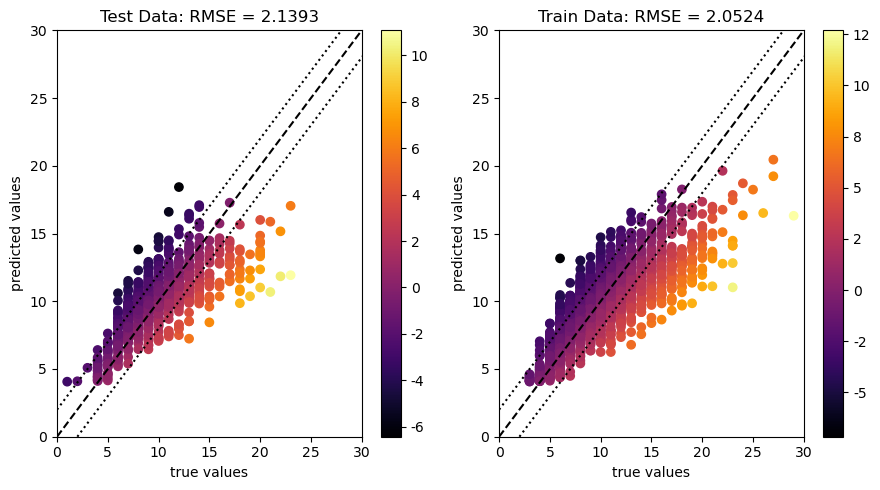

In [29]:
# new estimates
cbr_pred_train = cbr.predict(X_train)
cbr_pred_test = cbr.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))

title1 = f'Test Data: RMSE = %.5g' % (y_test - cbr_pred_test).std()
title2 = f'Train Data: RMSE = %.5g' % (y_train - cbr_pred_train).std()

scatter_res(axes[0], y_test, cbr_pred_test, title1)
scatter_res(axes[1], y_train, cbr_pred_train, title2)

plt.tight_layout()
plt.show()

In [30]:
cbr_pred_train = cbr.predict(X_train)
cbr_pred_test = cbr.predict(X_test)

# display evaluation scores
eval_metrics(cbr_pred_train, cbr_pred_test)

,MSE,RMSE,R²,MAE
Test,4.589306,2.139295,0.533128,1.572072
Train,4.212443,2.052418,0.601869,1.482475


> The performance on the test data slightly dropped compared to the previous results. However, this adjustment was worthwhile to achieve a more balanced model. The regressor's metrics for the training and test sets are relatively close, indicating reasonable generalization. Nonetheless, there is still a slight degree of overfitting present.

### 5. TensorFlow Neural Network

We will construct a simple neural network and replicate the previously developed multilayer perceptron. The loss function for model training will be mean squared error (MSE).

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

seed_value = 42
tf.random.set_seed(seed_value)

ann = keras.Sequential([
	layers.Dense(256, activation='relu', input_shape=[X_train.shape[1]]),
	layers.BatchNormalization(),
	layers.Dense(256, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(1, activation='relu'),
])

ann.compile( 
	loss='mse',
	optimizer='adam',
	metrics=['mape'],
)

In [32]:
# train neural network
history = ann.fit(
    X_train, y_train,
    epochs=60,
    verbose=1,
    batch_size=64,
    validation_data=(X_test, y_test),
) 

Epoch 1/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 66.4304 - mape: 75.8260 - val_loss: 43.1307 - val_mape: 53.6183
Epoch 2/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.9296 - mape: 45.2873 - val_loss: 12.0271 - val_mape: 23.3484
Epoch 3/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2902 - mape: 33.8974 - val_loss: 9.6419 - val_mape: 25.1513
Epoch 4/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8508 - mape: 30.8559 - val_loss: 10.0783 - val_mape: 29.6318
Epoch 5/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6761 - mape: 27.4596 - val_loss: 11.7438 - val_mape: 35.8103
Epoch 6/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2988 - mape: 25.3844 - val_loss: 10.3986 - val_mape: 32.9287
Epoch 7/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4561 - mape: 24.2356 - val_loss: 9.7017 - val_mape: 30.8766
Epoch 8/60
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7435 - mape: 23.1641 - val_loss: 8.7226 - val_mape: 28.0316
Epoch 9/60
49/49 ━━━━━━━━━━━━━

In [33]:
hist_df = pd.DataFrame(history.history)
hist_df.tail()

,loss,mape,val_loss,val_mape
55,4.629738,15.691442,4.654654,16.831467
56,4.646669,15.853790,4.444096,14.590884
57,4.583416,15.747896,4.852459,17.316864
58,4.637513,15.683327,4.431815,15.438088
59,4.536648,15.553764,4.421818,15.079771


To compute the feature importances for this regressor we can use a gradient-based method to measure the sensitivity of the model's output to changes in individual features. In neural networks, this involves computing how much a change in each feature (input) will affect the loss function.

One common approach is to compute the absolute gradients of the loss with respect to the input features.

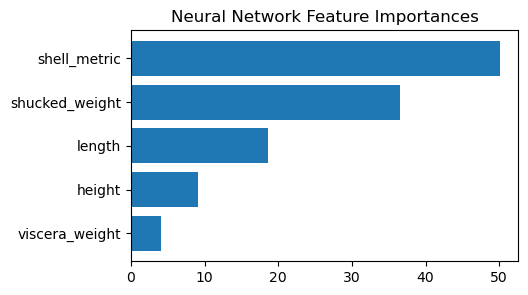

In [34]:
# compute gradients of the model's output (predictions) with respect to the input features
X_train_tensor = tf.Variable(X_train, dtype=tf.float32)

with tf.GradientTape() as tape:
    predictions = ann(X_train_tensor)
    
# compute gradients for each feature
grads = tape.gradient(predictions, X_train_tensor)

# the absolute gradients can be interpreted as feature importance
# convert the TensorFlow tensor to NumPy array
feature_importance = tf.reduce_mean(tf.abs(grads), axis=0)
feature_importance = feature_importance.numpy()

sorted_idx = np.argsort(feature_importance)
sorted_importances = feature_importance[sorted_idx]

plt.figure(figsize=(5, 3))
plt.barh(y=sorted_features[::-1], width=sorted_importances, align='center', capsize=2)
plt.title('Neural Network Feature Importances')
plt.show()

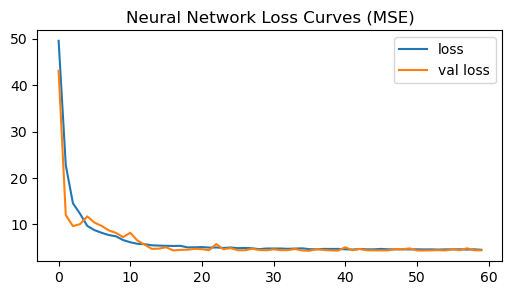

In [35]:
# visualize the loss curves
plt.figure(figsize=(6, 3))
plt.plot(hist_df['loss'], label='loss')
plt.plot(hist_df['val_loss'], label='val loss')
plt.title('Neural Network Loss Curves (MSE)')
plt.legend()
plt.show()

In [36]:
predictions = ann.predict(X_train, verbose=0)
ann_pred_train = np.squeeze(predictions)

predictions = ann.predict(X_test, verbose=0)
ann_pred_test = np.squeeze(predictions)

# display evaluation scores
eval_metrics(ann_pred_train, ann_pred_test)

,MSE,RMSE,R²,MAE
Test,4.421819,2.097471,0.599223,1.519808
Train,4.497469,2.117338,0.558188,1.539966


> The MSE and RMSE are slightly lower on test set than on train set. This suggests that the model performs marginally better on unseen data (test data) compared to the training data. Higher R² measure suggests the model is explaining more of the variance in the unseen data than it does on the training data. Overall, the model is not overfitting or underfitting; it's generalizing effectively.

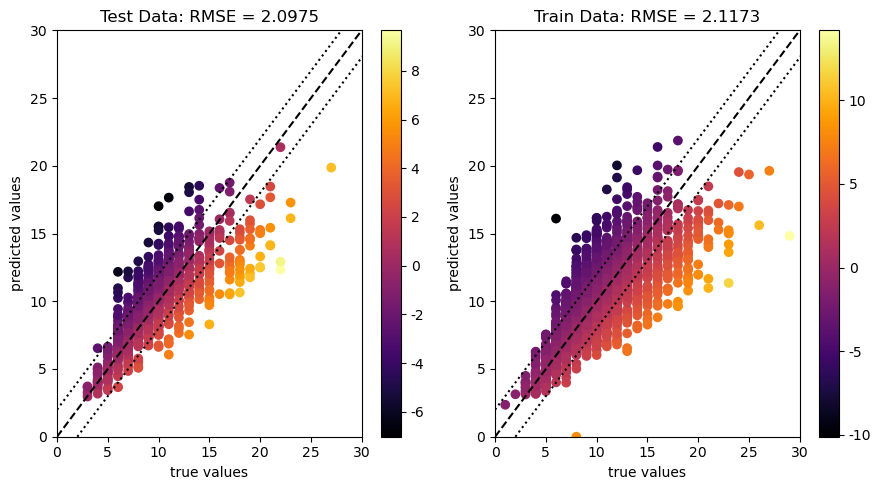

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

title1 = f'Test Data: RMSE = %.5g' % (y_test - ann_pred_test).std()
title2 = f'Train Data: RMSE = %.5g' % (y_train - ann_pred_train).std()

scatter_res(axes[0], y_test, ann_pred_test, title1)
scatter_res(axes[1], y_train, ann_pred_train, title2)

plt.tight_layout()
plt.show()

> The small gap in error metrics suggest the model's performance to be very well balanced.

### 6. Gaussian Process Regressor

The last model will be the Gaussian process regressor. This method depends on appropriate kernel (also called the covariance function) which is critical because the kernel defines the prior assumptions about the function we are trying to learn. Our start kernel will be defined as following:
* add a constant bias across all data points: this will add a uniform covariance;
* apply radial basis function (RBF): measures similarity and captures smoothness and decays with distance - closer points have higher similarity, decaying smoothly with distance;
* add white kernel: this adds variance (noise level) only when $x = x'$ else 0, modeling observation noise.

Mathematical expression of the kernel:

$$K (x, x') = 1 + 1 \times \exp \left(\frac{-(x - x')^2}{2 \times 10^2}\right) + 5 \times \delta (x, x').$$

In [38]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

# set up kernel
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10.0) + WhiteKernel(5.0)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    random_state=42,
).fit(X_train, y_train)

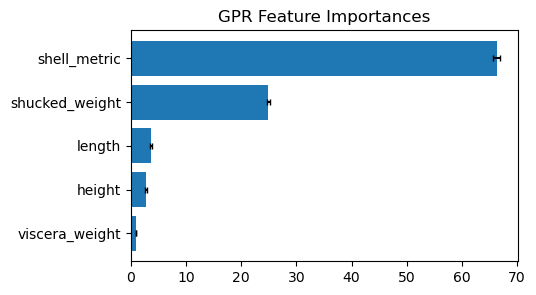

In [39]:
# compute permutation importance
results = permutation_importance(gpr, X_train, y_train, scoring='neg_mean_squared_error')

# get importance values: mean, std
importances = results.importances_mean
importances_std = results.importances_std

# sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_features = np.array(feature_list)[sorted_idx]
sorted_importances = importances[sorted_idx]
sorted_std = importances_std[sorted_idx]

plt.figure(figsize=(5, 3))
plt.barh(y=sorted_features[::-1], width=sorted_importances[::-1], xerr=sorted_std[::-1], align='center', capsize=2)
plt.title('GPR Feature Importances')
plt.show()

In [40]:
gpr_pred_train = gpr.predict(X_train)
gpr_pred_test = gpr.predict(X_test)

eval_metrics(gpr_pred_train, gpr_pred_test)

,MSE,RMSE,R²,MAE
Test,4.340534,2.083136,0.606591,1.487793
Train,4.295949,2.072667,0.577984,1.490126


> The model is generalizing well to unseen data. The test and train metrics are close which indicate that the model is not overfitting. The R² score show a reasonably good fit. The regressor is able to capture a significant portion of the target variable's variance.

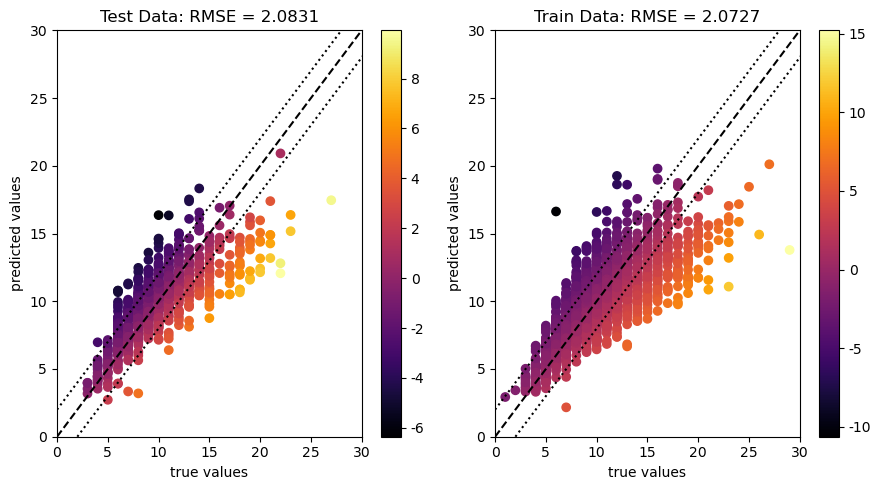

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

title1 = f'Test Data: RMSE = %.5g' % (y_test - gpr_pred_test).std()
title2 = f'Train Data: RMSE = %.5g' % (y_train - gpr_pred_train).std()

scatter_res(axes[0], y_test, gpr_pred_test, title1)
scatter_res(axes[1], y_train, gpr_pred_train, title2)

plt.tight_layout()
plt.show()

> No specific patterns are visible. The train data has much higher residuals.

Achieved test metrics for implemented models:

|         | MSE      | RMSE     | R²       | MAE      |
|---------|----------|----------|----------|----------|
| **MLP** | 4.307223 | 2.071724 | 0.561825 | 1.463248 |
| **CBR** | 4.589306 | 2.139295 | 0.533128 | 1.572072 |
| **ANN** | 4.421819 | 2.097471 | 0.599223 | 1.519808 |
| **GPR** | 4.340534 | 2.083136 | 0.606591 | 1.487793 |

### 7. Conclusions

In this notebook, the issue of abalone ring prediction was explored. Several models were utilized to estimate the data. Their evaluation was derived with standard regression metrics: MSE, RMSE, R², MAE. The introduced algorithms displayed reasonably good performances.

To determine the optimal model we want the error scores to be as low as possible and the coefficient of determination as high as possible (ideally closer to 1). The multilayer perceptron (MLP) has the lowest error metrics, indicating it has the smallest errors overall when compared to the other models. The Gaussian process regression (GPR) has the best R², which explains 60.7% of the variance in the data. This is a solid result, especially when compared to the other regressors.

The best option overall is GPR. While its MSE and RMSE are slightly higher than MLP model, it has the highest R² and a competitive MAE. This suggests that GPR is doing the best job in terms of explaining the variance in the data, with relatively low error rates. It balances error rates and variance explanation well. In case we want to prioritize minimizing error in terms of MSE/RMSE/MAE and can sacrifice a bit of R², MLP could be a good choice as well. The lower error metrics show that it generalizes to unseen data slightly better. Still, both regressors have very similar performance and differences are probably due to statistical fluctuations.

Achieving very good performance with Gaussian process regression depends greatly on kernel choice and is one of the most important components. This determines the structure of the function we are modeling and controls how points are related in the input space. Experimenting with different kernels (and combinations of them) can often significantly improve the performance.